# Locality Sensitive Hashing: Linear Algebra

This is a redo of Alex Klibisz's [sample notebook](https://github.com/alexklibisz/elastik-nearest-neighbors/blob/master/scratch/lsh-experiments/lsh-linear-algebra-1.ipynb) using [`plotly express`](https://medium.com/@plotlygraphs/introducing-plotly-express-808df010143d) instead of `matplotlib`.

In [14]:
import plotly_express as px
import plotly.graph_objs as go
import numpy as np
import pandas as pd

The linear algebra for LSH can be broken into two parts which is demonstrated using two-dimensional *points* and *lines* but also generalize to $d$-dimensional *vectors* and *hyperplanes*.

1. Given two points, $p = (1, 2)$ and $q = (2, 1)$, find the line $r$ equidistant and perpendicular to both points. This is done once for each bit in each hash function when you "fit" an LSH model using a random sample of points.
2. Use $r$ to formulate a hash function $h(v, r)$, such that for any new point $v$, if the point falls on one side of $r$, then $h(v, r) = 0$, and if it falls on the other side, then $h(v, r) = 1$. This is what happens when you "hash" a new point to approximate its location. You would do this multiple times to eventually represent the position as an integer comprised from the series of binary hashes.

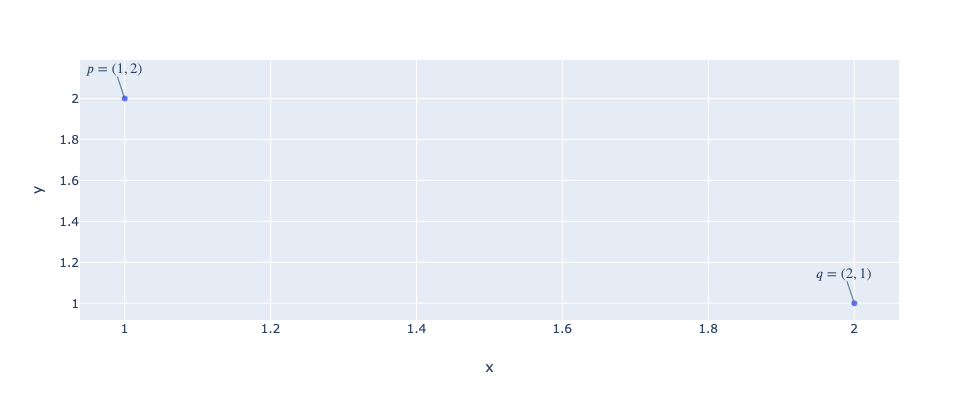

In [24]:
df = pd.DataFrame([[1,2], [2,1]], columns=['x','y'])
fig = px.scatter(df, x='x', y='y', width=400, height=400)
fig.update(layout=dict(annotations=[go.layout.Annotation(text='$p=(1,2)$', x=1, y=2),
                                    go.layout.Annotation(text='$q=(2,1)$', x=2, y=1)]))

For these two points you can visually deduce that the line $r$ will be a simple line with form $y = x$.

You can also imagine that if a point $v$ falls on $p$'s "side" of the line, then $h(v, r) = 1$, 
whereas if $v$ falls on $q$'s "side" of the line, then $h(v, r) = 0$.

In [39]:
# Two points to define the line y=x.
df['line_x'] = [0, 3]
df['line_y'] = [0, 3]

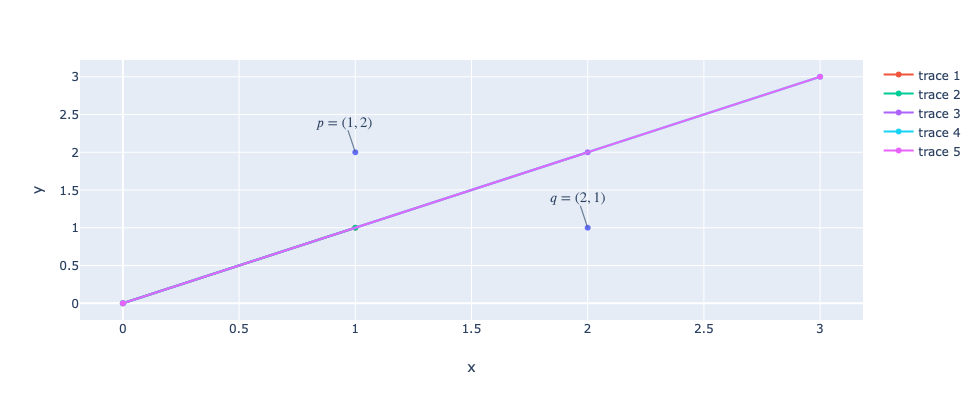

In [40]:
fig.add_scatter(x=df.line_x, y=df.line_y)
fig